In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.linalg as sl
import numpy as np
import pandas as pd
import arff
from copy import deepcopy
import tqdm

# additionally requires libcpab (https://github.com/SkafteNicki/libcpab)
import nwarp

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
# Please download the USP Data Stream repository from: https://sites.google.com/view/uspdsrepository
path_to_usp = '../../../../../../Documents/data/usp-stream-data'

dataset = 'INSECTS-abrupt_balanced'
#dataset = 'INSECTS-incremental_balanced'
#dataset = 'INSECTS-gradual_balanced'
#dataset = 'INSECTS-incremental-abrupt_balanced'
#dataset = 'INSECTS-incremental-reoccurring_balanced'

data_arff = arff.load(f'{path_to_usp}/{dataset}_norm.arff')
data = pd.DataFrame(list(data_arff))
data_x = data[range(33)]
data_y1hot = pd.get_dummies(data[33])
print(data_x.shape)

(52848, 33)


In [13]:
x_train = torch.as_tensor(data_x.values.astype(np.float32)).unsqueeze(0)
y_train1hot = torch.as_tensor(data_y1hot.values.astype(np.float32))
y_train = y_train1hot.argmax(-1).squeeze()

### Define model

In [18]:
N, T, Din = x_train.shape
_, Dout = y_train1hot.shape

K = 6
Dhidden = 8 # hidden dimension

# softmax regression with cross entropy loss (softmax performed in loss function)
glm = nwarp.GeneralizedLinearModel(Dout, invlink_func=nn.Identity())

# TSP-based parameter warping with constant mode vector
Dparamg = 0 # number of global parameters (same in every segment)
Dparaml = Dhidden*Dout # number of local parameters (different in every segment)
paramwarp = nwarp.ParameterWarp(K, Dparamg, Dparaml,
               nwarp.TSPStepWarp(nwarp.Constant((K-1,)),
                                 width=0.125, power=16.,
                                 min_step=0.0001, max_step=0.9999))

# feature transformation for the covariates
# map shape (T, Din) to shape (T, Dhidden)
covariates = nn.Sequential(
    nn.Linear(Din, Dhidden),
    nn.ReLU(),
)

print(covariates)
print(paramwarp)
print(glm)
#glm(covariates(x_train), paramwarp(x_train)[0])

Sequential(
  (0): Linear(in_features=33, out_features=8, bias=True)
  (1): ReLU()
)
ParameterWarp(
  (warp): TSPStepWarp(
    (loc_net): Constant()
  )
  (resample): Resample()
)
GeneralizedLinearModel(
  (invlink_func): Identity()
)


### Training

In [19]:
n_restarts    =  10 # number of randomized restarts
n_epochs      = 300 # total number of epochs
n_epochs_hard = 100 # use hard segmentation for the last X epochs
show_plots    = True
loss_fn       = nn.CrossEntropyLoss(reduction='mean')

restart  1/10: 100%|██████████| 300/300 [00:33<00:00,  9.02it/s, max=1.7896, cur=0.6174]


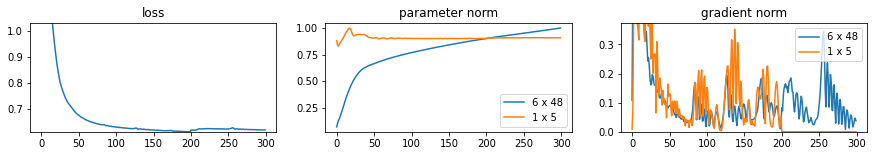

restart  2/10: 100%|██████████| 300/300 [00:33<00:00,  8.97it/s, max=1.7920, cur=0.6425]


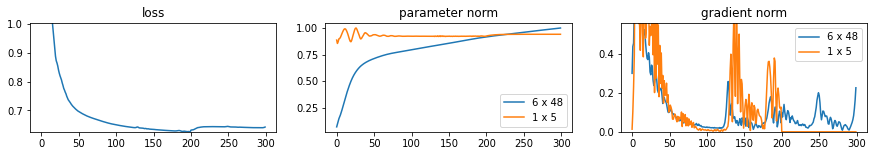

restart  3/10: 100%|██████████| 300/300 [00:32<00:00,  9.16it/s, max=1.7923, cur=0.6617]


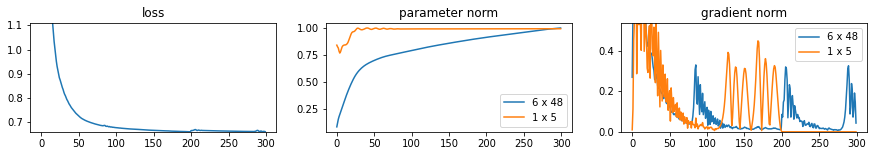

restart  4/10: 100%|██████████| 300/300 [00:33<00:00,  8.90it/s, max=1.7947, cur=0.6918]


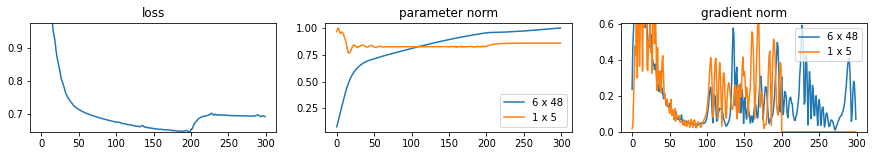

restart  5/10: 100%|██████████| 300/300 [00:34<00:00,  8.73it/s, max=1.7928, cur=0.7052]


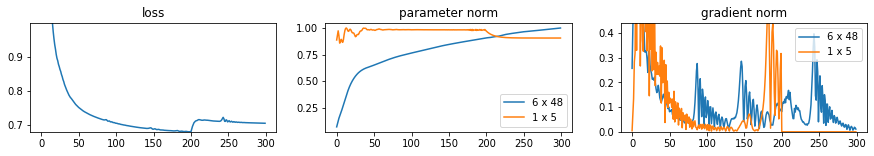

restart  6/10: 100%|██████████| 300/300 [00:31<00:00,  9.54it/s, max=1.7911, cur=0.6514]


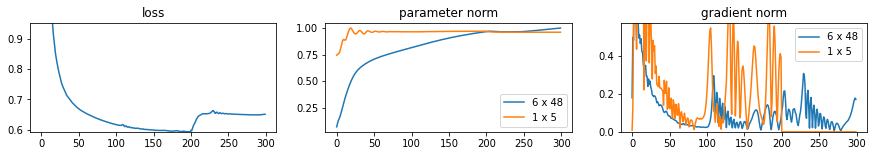

restart  7/10: 100%|██████████| 300/300 [00:30<00:00,  9.72it/s, max=1.7902, cur=0.6142]


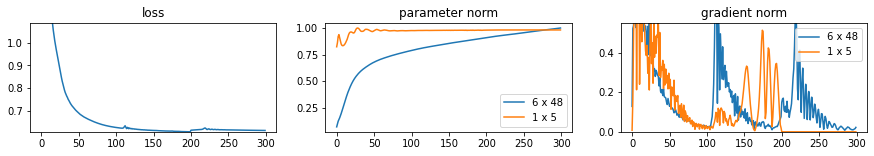

restart  8/10: 100%|██████████| 300/300 [00:32<00:00,  9.21it/s, max=1.7905, cur=0.6437]


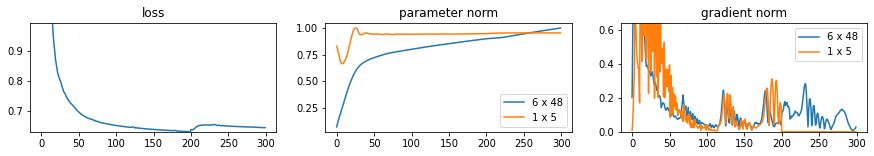

restart  9/10: 100%|██████████| 300/300 [00:29<00:00, 10.04it/s, max=1.7916, cur=0.6741]


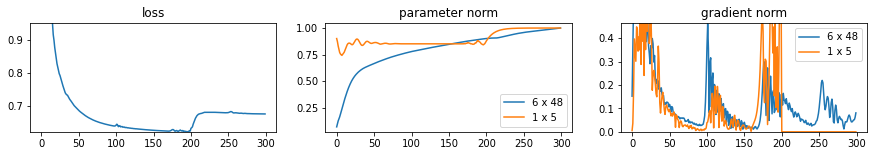

restart 10/10: 100%|██████████| 300/300 [00:33<00:00,  8.97it/s, max=1.7891, cur=0.6498]


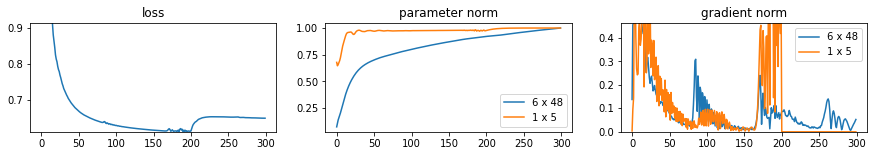

best loss = 0.6142


In [20]:
best_loss = np.inf
for r in range(n_restarts):
    # reset everything
    optimizer = torch.optim.Adam([
                        {'params': paramwarp.parameters(), 'lr': 1e-1},
                        {'params': covariates.parameters(), 'lr': 1e-1}
                ], weight_decay=0.0)
    param_norm = []
    grad_norm = []
    train_losses = []
    resample_kernel = 'linear'
    epoch_counter = tqdm.tqdm(range(n_epochs), desc=f'restart {(r+1):2d}/{n_restarts:2d}')

    # initialize parameters
    _ = covariates.apply(nwarp.reset_parameters)
    _ = paramwarp.apply(nwarp.reset_parameters)
    nn.init.uniform_(paramwarp.warp.loc_net.const, -1., 0.) # segmentation

    # perform training
    paramwarp.train()
    covariates.train()    
    for epoch in epoch_counter:
        optimizer.zero_grad()
        
        if epoch == n_epochs - n_epochs_hard:
            resample_kernel = 'integer'

        param_hat_train = paramwarp(x_train, # input is ignored, but must have shape (N, T, Din)
                              resample_kernel=resample_kernel)[0]
        y_hat_train = glm(covariates(x_train), param_hat_train)

        loss = loss_fn(y_hat_train.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        param_norm.append([sl.norm(p.detach()) for p in paramwarp.parameters() if len(p)>0])
        grad_norm.append([sl.norm(p.grad.detach()) for p in paramwarp.parameters() if len(p)>0])
        epoch_counter.set_postfix({'max': f'{max(train_losses):.4f}', 'cur': f'{loss.item():.4f}'})

    if train_losses[-1] < best_loss:
        best_paramwarp_state = deepcopy(paramwarp.state_dict())
        best_covariates_state = deepcopy(covariates.state_dict())
        best_loss = train_losses[-1]

    if show_plots:
        plt.figure(figsize=(15,2))
        plt.subplot(131)
        plt.title('loss')
        plt.ylim(np.min(train_losses), np.percentile(train_losses, 95))
        plt.plot(train_losses)

        plt.subplot(132)
        plt.title('parameter norm')
        lines = plt.plot(np.array(param_norm)/np.array(param_norm).max(axis=0))
        plt.legend(lines, [' x '.join([str(d) for d in p.size()]) for p in paramwarp.parameters() if len(p)>0])

        plt.subplot(133)
        plt.title('gradient norm')
        normalized_grad_norm = np.array(grad_norm)/np.array(grad_norm).max(axis=0)
        lines = plt.plot(normalized_grad_norm)
        plt.legend(lines, [' x '.join([str(d) for d in p.size()]) for p in paramwarp.parameters() if len(p)>0])
        plt.ylim(np.min(normalized_grad_norm), np.percentile(normalized_grad_norm, 95))

        plt.show()

paramwarp.eval()
covariates.eval()
paramwarp.load_state_dict(best_paramwarp_state)
covariates.load_state_dict(best_covariates_state)
print(f'best loss = {best_loss:.4f}')

In [21]:
param_hat_train, almat_hat_train, gamma_hat_train = paramwarp(x_train, # input is ignored, but must have shape (N, T, Din)
                                                              resample_kernel=resample_kernel)
y_hat_train = glm(covariates(x_train), param_hat_train)

In [27]:
print(dataset)
print(f'{K:2.0f}',
      f'{torch.sum(y_hat_train.argmax(-1) == y_train).item()/T:.2f}',
      end=' ')
print()
print('cps =', end=' ')
for cp in almat_hat_train.sum(dim=1).cumsum(dim=1).squeeze()[:-1]:
    print(f'{cp.item():.0f}', end=' ')
print()

INSECTS-abrupt_balanced
 6 0.74 
cps = 12748 18068 28104 38266 46879 
